In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf

In [2]:
import darts
import darts.utils.timeseries_generation as tg 
from darts.models import RNNModel
from darts.utils.likelihood_models import GaussianLikelihood
from darts.datasets import EnergyDataset, AirPassengersDataset

from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, mae, smape, rmse
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor,ModelCheckpoint, Timer, RichProgressBar
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from darts.timeseries import concatenate
from pandas import Timestamp

c:\ProgramData\anaconda3\envs\ai\lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [3]:
goog_ds = yf.download("GOOG",start="2015-01-01", end="2025-06-16", auto_adjust=False,
                    progress=False)

In [4]:
goog_ds

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,,
2015-01-02,26.014021,26.168653,26.490770,26.133251,26.378078,28951268
2015-01-05,25.471743,25.623152,26.144720,25.582764,26.091366,41196796
2015-01-06,24.881384,25.029282,25.738087,24.983908,25.679497,57998800
2015-01-07,24.838755,24.986401,25.292759,24.914099,25.280592,41301082
2015-01-08,24.917072,25.065184,25.105074,24.482782,24.831326,67071641
...,...,...,...,...,...,...
2025-06-09,177.630005,177.630005,177.914993,175.660004,175.869995,18817600
2025-06-10,180.009995,180.009995,182.445007,176.475006,177.759995,32908000


In [5]:
print(goog_ds.columns)

MultiIndex([('Adj Close', 'GOOG'),
            (    'Close', 'GOOG'),
            (     'High', 'GOOG'),
            (      'Low', 'GOOG'),
            (     'Open', 'GOOG'),
            (   'Volume', 'GOOG')],
           names=['Price', 'Ticker'])


In [6]:
# گام 1: کپی دیتافریم اصلی و ریست ایندکس برای برگردوندن تاریخ به ستون
df = goog_ds.copy().reset_index()

# گام 2: فقط ستون‌های عددی رو گرد کن (بدون دست زدن به ستون تاریخ)
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].round(3)

# گام 3: بررسی نتیجه
print(df.head())
print(df.dtypes)


Price        Date Adj Close   Close    High     Low    Open    Volume
Ticker                 GOOG    GOOG    GOOG    GOOG    GOOG      GOOG
0      2015-01-02    26.014  26.169  26.491  26.133  26.378  28951268
1      2015-01-05    25.472  25.623  26.145  25.583  26.091  41196796
2      2015-01-06    24.881  25.029  25.738  24.984  25.679  57998800
3      2015-01-07    24.839  24.986  25.293  24.914  25.281  41301082
4      2015-01-08    24.917  25.065  25.105  24.483  24.831  67071641
Price      Ticker
Date                 datetime64[ns]
Adj Close  GOOG             float64
Close      GOOG             float64
High       GOOG             float64
Low        GOOG             float64
Open       GOOG             float64
Volume     GOOG               int64
dtype: object


In [7]:
# تبدیل ستون‌ها به نام‌های ساده (Flat)
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# حالا چک کن ستون‌ها چه نام‌هایی دارن
print(df.columns)


Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [8]:
df

,Date,Adj Close,Close,High,Low,Open,Volume
0,2015-01-02,26.014,26.169,26.491,26.133,26.378,28951268
1,2015-01-05,25.472,25.623,26.145,25.583,26.091,41196796
2,2015-01-06,24.881,25.029,25.738,24.984,25.679,57998800
3,2015-01-07,24.839,24.986,25.293,24.914,25.281,41301082
4,2015-01-08,24.917,25.065,25.105,24.483,24.831,67071641
...,...,...,...,...,...,...,...
2623,2025-06-09,177.630,177.630,177.915,175.660,175.870,18817600
2624,2025-06-10,180.010,180.010,182.445,176.475,177.760,32908000
2625,2025-06-11,178.790,178.790,181.750,178.000,181.230,18994400
2626,2025-06-12,176.970,176.970,178.130,176.110,177.480,17345900


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2628 non-null   datetime64[ns]
 1   Adj Close  2628 non-null   float64       
 2   Close      2628 non-null   float64       
 3   High       2628 non-null   float64       
 4   Low        2628 non-null   float64       
 5   Open       2628 non-null   float64       
 6   Volume     2628 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 143.8 KB


In [10]:
df.isnull().sum()

Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [11]:
df.describe()

,Date,Adj Close,Close,High,Low,Open,Volume
count,2628,2628.000000,2628.000000,2628.000000,2628.000000,2628.000000,2.628000e+03
mean,2020-03-22 05:15:04.109588992,86.222762,86.684405,87.585959,85.759682,86.635374,3.044981e+07
min,2015-01-02 00:00:00,24.415000,24.560000,24.731000,24.311000,24.665000,6.809800e+06
25%,2017-08-10 18:00:00,46.902500,47.181500,47.488250,46.755250,47.088250,2.098060e+07
50%,2020-03-23 12:00:00,68.584500,68.992000,69.698000,67.616500,68.575000,2.667900e+07
75%,2022-10-28 18:00:00,127.899500,128.659750,130.547750,127.232750,129.100000,3.530110e+07
max,2025-06-13 00:00:00,207.225000,207.710000,208.700000,204.260000,204.500000,2.232980e+08
std,NaN,47.252497,47.438990,47.987026,46.914815,47.424135,1.525152e+07


<Axes: >

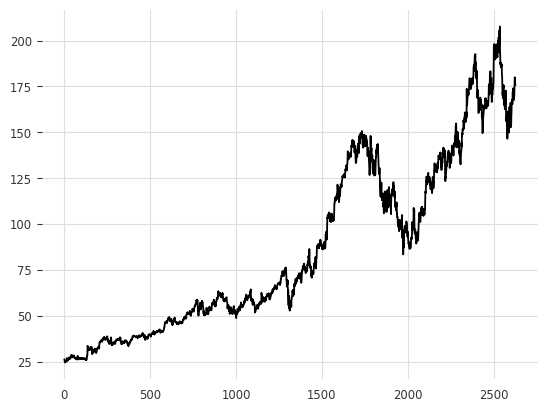

In [12]:
df.Close.plot()

In [13]:
# ساخت سری زمانی
goog_ts_daily = fill_missing_values(
    TimeSeries.from_dataframe(
    df=df,
    time_col='Date',
    value_cols=['Close'],
    fill_missing_dates=True,
    freq='D'
    ),fill = 'auto')

In [14]:
goog_ts_daily = goog_ts_daily.astype(np.float32)

In [15]:
goog_ts_daily

<TimeSeries (DataArray) (Date: 3816, component: 1, sample: 1)> Size: 15kB
array([[[ 26.169]],

       [[ 25.987]],

       [[ 25.805]],

       ...,

       [[178.79 ]],

       [[176.97 ]],

       [[175.88 ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 31kB 2015-01-02 2015-01-03 ... 2025-06-13
  * component  (component) object 8B 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [16]:
scaler_ts = Scaler()

In [17]:
goog_ts_daily_transform = scaler_ts.fit_transform(goog_ts_daily)

In [18]:
goog_ts_daily_transform

<TimeSeries (DataArray) (Date: 3816, component: 1, sample: 1)> Size: 15kB
array([[[0.00878516]],

       [[0.00779143]],

       [[0.00679772]],

       ...,

       [[0.84209657]],

       [[0.8321594 ]],

       [[0.826208  ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 31kB 2015-01-02 2015-01-03 ... 2025-06-13
  * component  (component) object 8B 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Date'>

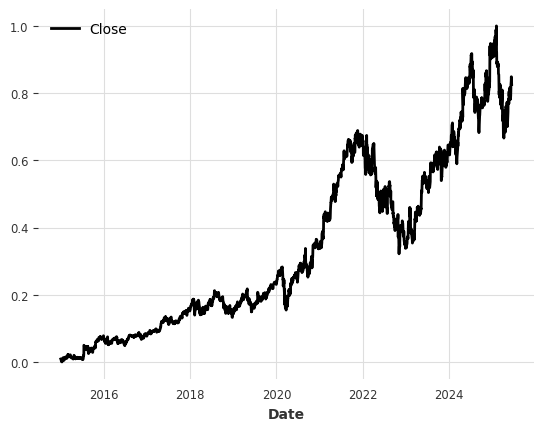

In [19]:
goog_ts_daily_transform.plot()

In [20]:
train_ts, val_test_ts = goog_ts_daily_transform.split_after(0.7)
val_ts, test_ts = val_test_ts.split_after(0.5)

In [21]:
train_ts

<TimeSeries (DataArray) (Date: 2671, component: 1, sample: 1)> Size: 11kB
array([[[0.00878516]],

       [[0.00779143]],

       [[0.00679772]],

       ...,

       [[0.52561283]],

       [[0.5322304 ]],

       [[0.5388479 ]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 21kB 2015-01-02 2015-01-03 ... 2022-04-25
  * component  (component) object 8B 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## past covariation

In [22]:
df_scaled = goog_ts_daily_transform.pd_dataframe()

# محاسبه میانگین متحرک 7 روزه
df_scaled['ma_7'] = df_scaled['Close'].rolling(window=7).mean().bfill()

# انحراف معیار متحرک 7 روزه
df_scaled['std_7'] = df_scaled['Close'].rolling(window=7).std().bfill()

# نرخ تغییر نسبت به 1 روز قبل
df_scaled['roc_1'] = df_scaled['Close'].pct_change(periods=1).bfill()

In [23]:
df_scaled.describe()

component,Close,ma_7,std_7,roc_1
count,3816.000000,3816.000000,3816.000000,3816.000000
mean,0.339487,0.338833,0.006690,inf
std,0.259335,0.258991,0.006406,NaN
min,0.000000,0.001107,0.000162,-1.000000
25%,0.123896,0.124037,0.002184,-0.008034
50%,0.243503,0.242251,0.004693,0.001123
75%,0.568453,0.572283,0.008979,0.009541
max,1.000000,0.976623,0.048134,inf


In [24]:
df_scaled.replace([np.inf, -np.inf], np.nan, inplace=True)
df_scaled = df_scaled.bfill().ffill()

In [25]:
row = 10
print(df_scaled[['Close', 'ma_7', 'std_7', 'roc_1']].iloc[row-7:row+1])


component      Close      ma_7     std_7     roc_1
Date                                              
2015-01-05  0.005804  0.005260  0.002697 -0.146186
2015-01-06  0.002561  0.005260  0.002697 -0.558795
2015-01-07  0.002326  0.005260  0.002697 -0.091685
2015-01-08  0.002757  0.005260  0.002697  0.185447
2015-01-09  0.000988  0.004146  0.002608 -0.641586
2015-01-10  0.000659  0.003128  0.002324 -0.333333
2015-01-11  0.000329  0.002204  0.001861 -0.500000
2015-01-12  0.000000  0.001374  0.001145 -1.000000


In [26]:
df_scaled.isnull().sum()

component
Close    0
ma_7     0
std_7    0
roc_1    0
dtype: int64

In [27]:
df_scaled.describe()

component,Close,ma_7,std_7,roc_1
count,3816.000000,3816.000000,3816.000000,3816.000000
mean,0.339487,0.338833,0.006690,0.002256
std,0.259335,0.258991,0.006406,0.061394
min,0.000000,0.001107,0.000162,-1.000000
25%,0.123896,0.124037,0.002184,-0.008034
50%,0.243503,0.242251,0.004693,0.001123
75%,0.568453,0.572283,0.008979,0.009541
max,1.000000,0.976623,0.048134,1.317826


In [28]:
df_scaled

component,Close,ma_7,std_7,roc_1
Date,,,,
2015-01-02,0.008785,0.005260,0.002697,-0.113114
2015-01-03,0.007791,0.005260,0.002697,-0.113114
2015-01-04,0.006798,0.005260,0.002697,-0.127539
2015-01-05,0.005804,0.005260,0.002697,-0.146186
2015-01-06,0.002561,0.005260,0.002697,-0.558795
...,...,...,...,...
2025-06-09,0.835763,0.811271,0.022070,0.005936
2025-06-10,0.848758,0.820865,0.021614,0.015548
2025-06-11,0.842097,0.828197,0.018129,-0.007848


In [29]:
df_scaled = df_scaled.reset_index()  # تاریخ رو از ایندکس به ستون بیار

In [30]:
past_cov = TimeSeries.from_dataframe(
    df_scaled,
    time_col="Date",
    value_cols=["ma_7", "std_7", "roc_1"]
)


In [31]:
past_cov.pd_dataframe().isna().sum()  # بررسی NaN
past_cov.pd_dataframe().isin([np.inf, -np.inf]).sum()  # بررسی inf


component
ma_7     0
std_7    0
roc_1    0
dtype: int64

In [32]:
scaler_cov = Scaler()
past_cov_scaled = scaler_cov.fit_transform(past_cov)

In [33]:
train_cov_pc, val_test_cov_pc = past_cov_scaled.split_after(0.7)
val_cov_pc, test_cov_pc = val_test_cov_pc.split_after(0.5)


## future covariation

In [34]:
# ایجاد هر ویژگی به‌صورت جداگانه
feat_day = datetime_attribute_timeseries(goog_ts_daily_transform, attribute="day", one_hot=True,dtype=np.float32)
feat_month = datetime_attribute_timeseries(goog_ts_daily_transform, attribute="month", one_hot=True,dtype=np.float32)
feat_weekday = datetime_attribute_timeseries(goog_ts_daily_transform, attribute="weekday", one_hot=True,dtype=np.float32)

# ترکیب ویژگی‌ها
time_feat = concatenate([feat_day, feat_month, feat_weekday], axis=1)

In [35]:
scaler_ts = Scaler()
time_feat_transform = scaler_ts.fit_transform(time_feat)
train_cov_tf , val_cov_test_tf = time_feat_transform.split_after(0.7)
val_cov_tf, test_cov_tf = val_cov_test_tf.split_after(0.5)

In [36]:
logger = CSVLogger("lightning_logs", name="deepar_logs")

In [37]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",       # پایش بر اساس val_loss برای جلوگیری از overfitting
        patience=15,              # اگر بهبود نداشت تا ۱۰ epoch، متوقف شود
        min_delta=0.1,
        mode="min"
    ),
    ModelCheckpoint(
        monitor="val_loss",       # ذخیره بهترین مدل بر اساس val_loss
        save_top_k=1,
        mode="min",
        filename="best-rnn-model",
        verbose=True
    ),
    LearningRateMonitor(logging_interval='epoch'),  # پایش و لاگ نرخ یادگیری
    Timer(),                                         # زمان‌سنج برای آموزش
    RichProgressBar()                               # نوار پیشرفت زیبا
]


In [38]:
model_deepar = RNNModel(
    model="LSTM",
    input_chunk_length=30,
    training_length=60,
    hidden_dim=64,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=32,
    n_epochs=200, 
    likelihood=GaussianLikelihood(),
    random_state=42,
    model_name="rnn_deepar",
    force_reset=True,
    save_checkpoints=False,
    optimizer_kwargs={"lr": 5e-3},
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs={
        "mode": "min",
        "factor": 0.5,
        "patience": 5
    },
    pl_trainer_kwargs={
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "enable_checkpointing": True,  # <-- Add this line back!
        "enable_progress_bar": True,
        "callbacks": callbacks,
        "logger": True
    }
)

In [39]:
torch.set_float32_matmul_precision('high')

In [ ]:
fited_model_deepar =model_deepar.fit(
                                    series=train_ts,
                                    #past_covariates=train_cov_pc,            # اگر past covariates داری
                                    future_covariates=train_cov_tf,           # ویژگی‌های زمانی آینده (temporal covariates)
                                    val_series=val_ts,
                                    #val_past_covariates=val_cov_pc,          # اگر past covariates داری
                                    val_future_covariates=val_cov_tf          # ویژگی‌های زمانی آینده برای اعتبارسنجی
                                )


In [ ]:
model_deepar.save("rnn_deepar_full")

In [ ]:
model_deepar_loaded = RNNModel.load("rnn_deepar_full")

# حالا فایل checkpoint رو بارگذاری کن:
model_deepar_loaded = model_deepar.load_from_checkpoint(
    model_name="rnn_deepar",
    work_dir="projects/lightning_logs/version_21",
    file_name="epoch=33-step=1700.ckpt",
)

In [ ]:
# ⚙️ گرفتن مقادیر لازم از مدل و تست‌ست
input_chunk_length = model_deepar_loaded.input_chunk_length
forecast_horizon = len(test_ts)

# 🧠 ساخت بازه زمانی لازم برای future_covariates
start_cov = test_ts.start_time() - pd.Timedelta(days=input_chunk_length)
end_cov = test_ts.end_time() + pd.Timedelta(days=forecast_horizon)

# 📅 تولید تقویم کامل از تاریخ شروع تا پایان پیش‌بینی
full_cov_dates = pd.date_range(start=start_cov, end=end_cov, freq="D")

# 🔁 تولید چند ویژگی زمانی جداگانه
feat_day = datetime_attribute_timeseries(full_cov_dates, attribute="day", one_hot=True, dtype=np.float32)
feat_month = datetime_attribute_timeseries(full_cov_dates, attribute="month", one_hot=True, dtype=np.float32)
feat_weekday = datetime_attribute_timeseries(full_cov_dates, attribute="weekday", one_hot=True, dtype=np.float32)

# 🔗 ترکیب همه ویژگی‌ها در یک TimeSeries
future_feat_full = concatenate([feat_day, feat_month, feat_weekday], axis=1)

# ⚖️ مقیاس‌گذاری با Scaler قبلاً fit شده روی train
test_cov_future = scaler_ts.transform(future_feat_full)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

✅ Test MAE: 0.16929222533961277
✅ Test MAPE: 20.80575779646239


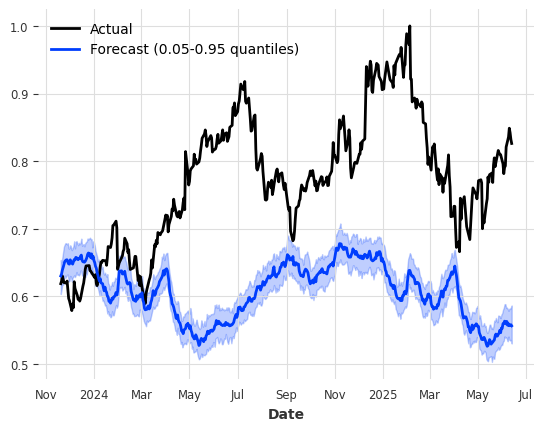

In [ ]:
# پیش‌بینی روی test_ts
pred_test = model_deepar_loaded.predict(
    n=len(test_ts),
    series=train_ts.append(val_ts),
    future_covariates=test_cov_future,
    num_samples=100
)

# ارزیابی فقط روی بخش همپوشان
actual = test_ts.slice_intersect(pred_test)
forecast = pred_test.slice_intersect(test_ts)

if len(actual) > 0 and len(forecast) > 0:
    print("✅ Test MAE:", mae(actual, forecast))
    print("✅ Test MAPE:", mape(actual, forecast))

    actual.plot(label='Actual')
    forecast.plot(label='Forecast (0.05-0.95 quantiles)')
else:
    print("❌ No valid overlapping data between test set and prediction.")

In [ ]:
print(f"تعداد پیش‌بینی‌ها: {len(pred_test)}")

تعداد پیش‌بینی‌ها: 572


### historical_forecasts

In [ ]:
# فرض کنید val_ts و val_cov_tf داده‌های اعتبارسنجی هستند
fit_kwargs = {
    "val_series": val_ts,
    "val_future_covariates": val_cov_tf,
    # اگر past_covariates دارید:
    # "val_past_covariates": val_cov_pc,
}

historical_forecasts_goog = model_deepar_loaded.historical_forecasts(
    series=goog_ts_daily_transform,
    future_covariates=time_feat,
    num_samples=40,
    start=0.8,
    forecast_horizon=14,
    retrain=False,
    stride=30,
    last_points_only=False,
    fit_kwargs=fit_kwargs  # این خط را اضافه کنید
)


In [ ]:
import pickle

with open("historical_forecasts_goog.pkl", "wb") as f:
    pickle.dump(historical_forecasts_goog, f)


In [ ]:
import pickle

# بارگذاری فایل
with open("historical_forecasts_goog.pkl", "rb") as f:
    historical_forecasts_goog = pickle.load(f)


In [ ]:
error_score = model_deepar_loaded.backtest(
    series=goog_ts_daily_transform,
    future_covariates=time_feat,
    historical_forecasts=historical_forecasts_goog,
    metric=[mae, mape, smape, rmse],
    retrain=False,
    verbose=True,
    last_points_only=False
)


In [ ]:
print(f"MAE: {error_score[0]} , MAPA: {error_score[1]} , smape: {error_score[2]} , rmse: {error_score[3]}" )

MAE: 0.09355639396133004 , MAPA: 12.000776477356101 , smape: 13.147457105789666 , rmse: 0.09980103895844078


## gridSearch 

In [ ]:
callbacks = [
    EarlyStopping(
        monitor="train_loss",       # پایش بر اساس val_loss برای جلوگیری از overfitting
        patience=15,              # اگر بهبود نداشت تا ۱۰ epoch، متوقف شود
        min_delta=0.1,
        mode="min"
    ),
    ModelCheckpoint(
        monitor="train_loss",       # ذخیره بهترین مدل بر اساس val_loss
        save_top_k=1,
        mode="min",
        filename="best-rnn-model_hyper",
        verbose=True
    ),
    LearningRateMonitor(logging_interval='epoch'),  # پایش و لاگ نرخ یادگیری
    Timer(),                                         # زمان‌سنج برای آموزش
    RichProgressBar()                               # نوار پیشرفت زیبا
]


In [ ]:
param_grid = {
    "input_chunk_length": [20, 30],
    "training_length": [40,60, 80],
    "hidden_dim": [64, 128],
    "n_rnn_layers": [2,3],
    "dropout": [0.2, 0.4],
    "batch_size": [32],
    "n_epochs": [50],  # ثابت برای سرعت
    "model": ["LSTM"],  # اگر فقط LSTM است

    "force_reset": [True],
    "optimizer_kwargs": [{"lr": 5e-3}],
    "lr_scheduler_cls": [torch.optim.lr_scheduler.ReduceLROnPlateau],
    "lr_scheduler_kwargs": [{
        "mode": "min",
        "factor": 0.5,
        "patience": 5,
        "monitor": "train_loss"  # حذف شود چون باعث خطا می‌شود
    }],
    "pl_trainer_kwargs": [{
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "enable_checkpointing": True,
        "enable_progress_bar": True,
        "callbacks": callbacks,
        "logger": True
    }]
}


### حالت ارزیابی با اعتبارسنجی (split mode)

In [ ]:
best_model_sl_tuple= RNNModel.gridsearch(
    parameters=param_grid,
    series=train_ts,
    val_series=val_ts,
    future_covariates=time_feat,           # اگر داری
    # forecast_horizon=None, use_fitted_values=False
    metric=mae,
    verbose=True,
    n_jobs=4
)


gridsearch:   0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
(best_model_sl, best_params_sl, best_score_sl) = best_model_sl_tuple

### حالت backtesting چند مرحله‌ای (expanding window mode):

In [ ]:
best_model_bk_tuple = RNNModel.gridsearch(
    parameters=param_grid,
    series=goog_ts_daily_transform,
    forecast_horizon=10,
    future_covariates=time_feat,   # اگر داری
    start=0.9,
    stride=30,
    metric=mape,
    verbose=True,
    n_jobs=4
)


In [ ]:
(best_model_bk, best_params_bk, best_score_bk) = best_model_bk_tuple

###  حالت evaluation روی داده train (fitted values mode):

In [ ]:
best_model_ev_tuple = RNNModel.gridsearch(
    parameters=param_grid,
    series=train_ts,
    use_fitted_values=True,
    metric=mae,
    verbose=True,
    n_jobs=4
)


In [ ]:
(best_model_ev, best_params_ev, best_score_ev) = best_model_ev_tuple

In [ ]:
# 🔮 پیش‌بینی مدل Split Validation
forecast_sl = best_model_sl.predict(n=10, series=val_ts, future_covariates=val_cov_tf)
aligned_sl = val_ts.slice_intersect(forecast_sl)
mae_sl = mae(aligned_sl, forecast_sl)
mape_sl = mape(aligned_sl, forecast_sl)

# 🔮 پیش‌بینی مدل Backtest
forecast_bk = best_model_bk.predict(n=10, series=val_ts, future_covariates=val_cov_tf)
aligned_bk = val_ts.slice_intersect(forecast_bk)
mae_bk = mae(aligned_bk, forecast_bk)
mape_bk = mape(aligned_bk, forecast_bk)

# 🔮 پیش‌بینی مدل Eval on Train
forecast_ev = best_model_ev.predict(n=10, series=val_ts, future_covariates=val_cov_tf)
aligned_ev = val_ts.slice_intersect(forecast_ev)
mae_ev = mae(aligned_ev, forecast_ev)
mape_ev = mape(aligned_ev, forecast_ev)

# 📊 رسم نمودار مقایسه‌ای مدل‌ها
plt.figure(figsize=(14, 6))
aligned_sl.plot(label=f"Split Val Forecast (MAE: {mae_sl:.4f}, MAPE: {mape_sl:.2f}%)", color="blue")
aligned_bk.plot(label=f"Backtest Forecast (MAE: {mae_bk:.4f}, MAPE: {mape_bk:.2f}%)", color="green")
aligned_ev.plot(label=f"Eval on Train (MAE: {mae_ev:.4f}, MAPE: {mape_ev:.2f}%)", color="orange")
val_ts.plot(label="Actual", color="black")

plt.title("📊 مقایسه مدل‌های GridSearch: Split / Backtest / Eval")
plt.xlabel("تاریخ")
plt.ylabel("مقدار پیش‌بینی‌شده")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from darts.models import NBEATSModel
from darts.metrics import mae, mape
from darts.utils.likelihood_models import GaussianLikelihood
from pytorch_lightning.callbacks import (
    EarlyStopping, ModelCheckpoint, LearningRateMonitor, Timer, RichProgressBar
)
from pytorch_lightning.loggers import CSVLogger
import torch

In [ ]:

# ساخت Logger
logger_nbeats = CSVLogger("lightning_logs", name="nbeats_logs")

# تعریف callbacks دقیقاً مشابه قبلی
callbacks_nbeats = [
    EarlyStopping(
        monitor="val_loss",
        patience=15,
        min_delta=0.1,
        mode="min"
    ),
    ModelCheckpoint(
        monitor="val_loss",
        save_top_k=1,
        mode="min",
        filename="best-nbeats-model",
        verbose=True
    ),
    LearningRateMonitor(logging_interval='epoch'),
    Timer(),
    # RichProgressBar()
]

# تعریف مدل N-BEATS با ساختار مشابه RNNModel شما
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    n_epochs=200,
    batch_size=32,
    random_state=42,
    model_name="nbeats_model",
    force_reset=True,
    save_checkpoints=False,
    likelihood=GaussianLikelihood(),  # اگر بخواهید شبیه DeepAR شود
    optimizer_kwargs={"lr": 5e-3},
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs={
        "mode": "min",
        "factor": 0.5,
        "patience": 5
    },
    pl_trainer_kwargs={
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "enable_checkpointing": True,
        "enable_progress_bar": True,
        "callbacks": callbacks_nbeats,
        "logger": logger_nbeats
    }
)

In [ ]:
train_ts = train_ts.astype(np.float32)
val_ts = val_ts.astype(np.float32)
train_cov_pc = train_cov_pc.astype(np.float32)
val_cov_pc = val_cov_pc.astype(np.float32)


In [ ]:
fited_model_nbeats = model_nbeats.fit(
                                    series=train_ts,
                                    past_covariates=train_cov_pc,
                                    val_series=val_ts,
                                    val_past_covariates=val_cov_pc
                                )

model_nbeats.save("nbeats_model_full")

In [ ]:
from darts.models import NBEATSModel
from darts.metrics import mae, mape
import torch
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor, Timer
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBar

callbacks = [
    EarlyStopping(monitor="train_loss", patience=10, min_delta=1e-3, mode="min"),
    ModelCheckpoint(monitor="train_loss", save_top_k=1, mode="min", filename="best-nbeats-model"),
    LearningRateMonitor(logging_interval='epoch'),
    Timer(),
    RichProgressBar()
]

param_grid_nbeats = {
    "input_chunk_length": [30, 50],
    "output_chunk_length": [10],  # forecast_horizon = 10
    "n_epochs": [50],
    "batch_size": [32],
    "num_blocks": [2, 3],
    "layer_widths": [[64], [128]],
    "optimizer_kwargs": [{"lr": 1e-3}],
    "force_reset": [True],
    "pl_trainer_kwargs": [{
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "enable_checkpointing": True,
        "enable_progress_bar": True,
        "callbacks": callbacks
    }]
}


In [ ]:
best_model_nbeats, best_params_nbeats, best_score_nbeats = NBEATSModel.gridsearch(
    parameters=param_grid_nbeats,
    series=train_ts,
    val_series=val_ts,
    future_covariates=train_cov_tf,
    metric=mae,
    verbose=True,
    n_jobs=2
)


In [ ]:
forecast_nbeats = best_model_nbeats.predict(n=10, series=val_ts, future_covariates=val_cov_tf)
aligned_nbeats = val_ts.slice_intersect(forecast_nbeats)

mae_nbeats = mae(aligned_nbeats, forecast_nbeats)
mape_nbeats = mape(aligned_nbeats, forecast_nbeats)

print(f"N-BEATS → MAE: {mae_nbeats:.4f}, MAPE: {mape_nbeats:.2f}%")


In [ ]:
forecast_deepar = best_model_deepar.predict(n=10, series=val_ts, future_covariates=val_cov_tf)
aligned_deepar = val_ts.slice_intersect(forecast_deepar)

mae_deepar = mae(aligned_deepar, forecast_deepar)
mape_deepar = mape(aligned_deepar, forecast_deepar)

print(f"DeepAR → MAE: {mae_deepar:.4f}, MAPE: {mape_deepar:.2f}%")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
aligned_nbeats.plot(label=f"N-BEATS (MAE: {mae_nbeats:.4f}, MAPE: {mape_nbeats:.2f}%)", color="blue")
aligned_deepar.plot(label=f"DeepAR (MAE: {mae_deepar:.4f}, MAPE: {mape_deepar:.2f}%)", color="green")
val_ts.plot(label="Actual", color="black")

plt.title("مقایسه عملکرد N-BEATS و DeepAR")
plt.xlabel("تاریخ")
plt.ylabel("مقدار")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
